In [1]:
import os
import cv2
import numpy as np
from copy import deepcopy

from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# custom package imports
from Helpers_Localization import helper_model
from Helpers_Localization import helper_data
from Helpers_Localization import helper_stats
from Helpers_Localization import helper_losses

Using TensorFlow backend.


In [70]:
import glob
import pandas as pd
import seaborn as sns

In [71]:
path = r'csv'
csv_files = glob.glob(path + "/*.csv")

In [72]:
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
big_df   = pd.concat(df_list, ignore_index=True)

In [75]:
df = big_df.loc[big_df['class'] == 'dash']

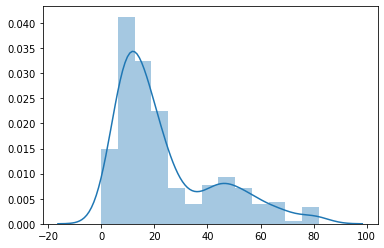

In [76]:
sns.distplot(df['ymax']-df['ymin'])

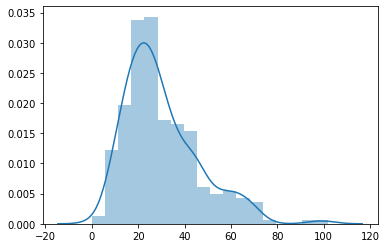

In [77]:
sns.distplot(df['xmax']-df['xmin'])

In [25]:
sns.countplot(x='xmin', data=big_df,hue='class')

ValueError: Could not interpret input 'xmin-xmax'

In [2]:
# --- paths ---
version = 'LV04_v8'

# NOTE: specify destination paths
srcImagesPath = r'C:\Users\vase_\Downloads\mobile-robotics\snapshots'

srcAnnotationsPath = r'C:\Users\vase_\Downloads\mobile-robotics\csv'
dstModelsPath = r'C:\Users\vase_\Downloads\mobile-robotics\model'

# create folders to save data from the current execution
if not os.path.exists(os.path.join(dstModelsPath, version)):
    os.mkdir(os.path.join(dstModelsPath, version))
else:
    # to avoid overwriting training results
    print(f"Folder name {version} exists.")
    exit(1)

modelsPath = os.path.join(dstModelsPath, version)


# --- variables ---
class_names = ('dash', 'whole')   # the element index marks the integer coding of classes (bgr - 0, cars - 1)

imgDims = {'rows': 224, 'cols': 224}    # input image dimensions
num_classes = 1
img_depth = 1
img_dims = (imgDims['rows'], imgDims['cols'], img_depth)


In [51]:
x_train_orig, bboxes_train = helper_data.read_data_rpn(os.path.join(srcImagesPath, 'train'), (imgDims['cols'], imgDims['rows']), img_depth, srcAnnotationsPath, exclude_empty=True, shuffle=False)
x_val_orig, bboxes_val = helper_data.read_data_rpn(os.path.join(srcImagesPath, 'val'), (imgDims['cols'], imgDims['rows']), img_depth, srcAnnotationsPath, exclude_empty=True, shuffle=False)

100%|██████████| 12/12 [00:00<00:00, 61.08it/s]


In [78]:
# --- prepare ground truth data in required CNN output format ---
anchor_dims = ((12,20), (16,20), (8,20), (50,20), (60,40), (60,60))   # anqors (height, width)
anchor_stride = 4      # NOTE: depends on the model configuration

# iou thresholds for positive and negative samples
iou_low = 0.3
iou_high = 0.6
num_negs_ratio = 10     # select X times more negative than positive samples

In [79]:
y_class_train, valid_train = helper_data.get_anchor_data_cls(bboxes_train, anchor_dims, img_dims, anchor_stride, iou_low, iou_high, num_negs_ratio)
y_class_val, valid_val = helper_data.get_anchor_data_cls(bboxes_val, anchor_dims, img_dims, anchor_stride, iou_low, iou_high, num_negs_ratio)

71it [00:40,  1.74it/s]
12it [00:06,  1.90it/s]


In [80]:
x_train = []
for valid_ind in valid_train:
    x_train.append(x_train_orig[valid_ind])
x_train = np.array(x_train)
x_val = []
for valid_ind in valid_val:
    x_val.append(x_val_orig[valid_ind])
x_val = np.array(x_val)

In [81]:
print(f'Number of positive samples in training set: {np.sum(y_class_train[:, :, :, -1])}')
print(f'Number of positive samples in validation set: {np.sum(y_class_val[:, :, :, -1])}')

Number of positive samples in training set: 11390
Number of positive samples in validation set: 1610


In [82]:
epochs = 20
lr = 0.0001
batch_size = 15      # number of samples to process before updating the weights

model = helper_model.construct_model_ssd_cls(input_shape=img_dims, num_anchors=len(anchor_dims))   # build model architecture

# compile model
model.compile(loss={
                  'rpn_out_class': helper_losses.rpn_loss_cls_multilabel,     # loss function to be applied to the output layer named rpn_out_class
                   },
              optimizer=Adam(lr=lr),
              metrics=['accuracy'])


# --- fit model ---
model_checkpoint = ModelCheckpoint(filepath=os.path.join(modelsPath, 'checkpoint-{epoch:03d}-{val_accuracy:.4f}.hdf5'),   # epoch number and val accuracy will be part of the weight file name
                                   monitor='val_accuracy',      # metric to monitor when selecting weight checkpoints to save
                                   verbose=1,
                                   save_best_only=False)     # True saves only the weights after epochs where the monitored value (val accuracy) is improved


In [84]:
history = model.fit(x_train, y_class_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[model_checkpoint],
                    verbose=1,
                    validation_data=(x_val, y_class_val),
                    shuffle=True)


Train on 64 samples, validate on 11 samples
Epoch 1/20
64/64 [==============================] - 2s 28ms/step - loss: 71.8579 - accuracy: 1.2456e-04 - val_loss: 41.1068 - val_accuracy: 1.7393e-04

Epoch 00001: saving model to C:\Users\vase_\Downloads\mobile-robotics\model\LV04_v8\checkpoint-001-0.0002.hdf5
Epoch 2/20
64/64 [==============================] - 1s 20ms/step - loss: 33.6769 - accuracy: 6.5270e-04 - val_loss: 16.7668 - val_accuracy: 0.0042

Epoch 00002: saving model to C:\Users\vase_\Downloads\mobile-robotics\model\LV04_v8\checkpoint-002-0.0042.hdf5
Epoch 3/20
64/64 [==============================] - 1s 22ms/step - loss: 10.9336 - accuracy: 0.0100 - val_loss: 3.4294 - val_accuracy: 0.0238

Epoch 00003: saving model to C:\Users\vase_\Downloads\mobile-robotics\model\LV04_v8\checkpoint-003-0.0238.hdf5
Epoch 4/20
64/64 [==============================] - 1s 21ms/step - loss: 2.6755 - accuracy: 0.0437 - val_loss: 3.1605 - val_accuracy: 0.0524

Epoch 00004: saving model to C:\Users\

In [11]:
# --- save model ---
# save model architecture
print(model.summary())      # parameter info for each layer
with open(os.path.join(modelsPath, 'modelSummary.txt'), 'w') as fh:     # save model summary
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
plot_model(model, to_file=os.path.join(modelsPath, 'modelDiagram.png'), show_shapes=True)   # save diagram of model architecture

# save model configuration and weights
model_json = model.to_json()  # serialize model architecture to JSON
with open(os.path.join(os.path.join(modelsPath, 'model.json')), "w") as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(modelsPath, 'model.h5'))  # serialize weights to HDF5
print("Saved model to disk.")


# --- save training curves and logs ---
helper_stats.save_training_logs(history=history, dst_path=modelsPath)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0   

In [63]:
im_path = r'C:\Users\vase_\Downloads\mobile-robotics\data'
index = 0
im_name = str(index) + '.jpg'
x_test = cv2.imread(os.path.join(im_path, im_name),0)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
#images_list = np.array([x_test,x_test]).astype(np.uint8)
x_test = np.expand_dims(x_test, axis=0)
output_cls = model.predict(x_val, verbose=1)
helper_data.save_results_cls_square(im_path, x_test, plot_color, output_cls, anchor_dims, anchor_stride, prob_thr)

8/8 [==============================] - 0s 4ms/step


1it [00:00, 100.55it/s]


In [86]:
resultsPath =r'C:\Users\vase_\Downloads\mobile-robotics\result'
prob_thr = 0.9  # probability threshold
plot_color = (0, 255, 0)    # color of resulting bounding boxes

In [87]:
output_cls = model.predict(x_val, verbose=1)
helper_data.save_results_cls_square(os.path.join(resultsPath, 'test'), x_val, plot_color, output_cls, anchor_dims, anchor_stride, prob_thr)

11/11 [==============================] - 0s 4ms/step


11it [00:00, 344.91it/s]


In [83]:
helper_data.save_results_cls_square(os.path.join(resultsPath, 'true'), x_val, plot_color, y_class_val, anchor_dims, anchor_stride, prob_thr)

11it [00:00, 400.66it/s]


In [50]:
x_val.shape

(8, 224, 224, 1)

In [52]:
imgVis = deepcopy(x_val_orig[0])
for bb in bboxes_val[0]:
    cv2.rectangle(imgVis, (bb[1], bb[0]), (bb[3], bb[2]), color=(255))  # visualize all annotated objects

In [53]:
cv2.imshow("image", imgVis)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
bboxes_train[0]

[[121, 29, 166, 48], [92, 97, 105, 130], [89, 139, 98, 160]]

In [53]:
imgVis = deepcopy(x_train_orig[0])
cv2.rectangle(imgVis, (29, 121), (48, 166), color=(255))
cv2.imshow("image", imgVis)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
im_path = r'C:\Users\vase_\Downloads\mobile-robotics\snapshots\train\0.jpg'
index = 0
im_name = str(index) + '.jpg'
imgVis = cv2.imread(im_path,0)
cv2.rectangle(imgVis, (29, 121), (48, 166), color=(255))
cv2.imshow("image", imgVis)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
imgVis.shape

(224, 224)

In [16]:
if (224,224) != (imgVis.shape[1], imgVis.shape[0]):   
        print("ok")

